In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.datasets import cifar10
import numpy as np

Using TensorFlow backend.


In [2]:
def display_images(image, description=''):
    if len(image.shape) == 4:
        plt.imshow(image[0])
    else:
        plt.imshow(image)
    plt.title(description)
    plt.axis('off')
    plt.show()

In [3]:
class ProjectedGradientDescent:
    def __init__(self, model, orig_image, target_label):
        self.loss = tf.keras.losses.CategoricalCrossentropy()
        self.iters = 10
        self.norm = 'l2'
        self.lr = 0.5
        self.eps = 60
        self.orig_image = orig_image
        self.model = model
        self.target_label = target_label
    
    def step(self, image):
        with tf.GradientTape() as tape:
            tape.watch(image)
            pred = self.model(image)
            loss = self.loss(self.target_label, pred)
    
        grad = tape.gradient(loss, image)
        signed_grad = tf.sign(grad)
        
        image += self.lr * signed_grad
        
        diff = image - self.orig_image
        if self.norm == 'l2':
            diff = tf.clip_by_norm(diff, self.eps)
        elif self.norm == 'inf':
            diff = tf.clip_by_value(diff, -self.eps, self.eps)
            
        image = tf.clip_by_value(self.orig_image+diff, 0, 1)
        
        return image
    
    def gen_adv_example(self, showImage=False):
        if showImage:
            display_images(self.orig_image, "Orig image")
            
        image = self.orig_image    
        for i in range(self.iters):
            image = self.step(image)
            
        if showImage:
            display_images(image, "Orig image")

        return image

        
class Generator:
    def __init__(self):
        self.means = []
        self.covs = []
        self.orig_shape = None
        
    def calc_class_stats(self):
        (x_train, y_train), (x_test, y_test) = cifar10.load_data()
        self.orig_shape = x_train[0].shape
        
        for k in range(10):
            bol = (y_train == k).reshape(-1)
            sub_x = x_train[bol]
            mean = np.mean(sub_x, axis=0).flatten()
            sub_x = sub_x.reshape(sub_x.shape[0], -1)
            cov = (sub_x-mean).T @ (sub_x-mean) / len(mean)
            
            self.means.append(mean)
            self.covs.append(cov)
            
    def generate_seed(self, class_id):
        sample = np.rint(np.random.multivariate_normal(self.means[class_id], self.covs[class_id])).astype(int).reshape(self.orig_shape)
        sample = np.clip(sample, 0, 255)
        return sample
        
    def visualize_example_seeds(self, count=3):
        for k in range(count):
            sample = self.generate_seed(k)
            display_images(sample, "Example seed from class {}".format(k))

In [4]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize(image, (224, 224))
    image = image[None, ...]
    return image

# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [5]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

image_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)

image = preprocess(image)
image_probs = pretrained_model.predict(image)

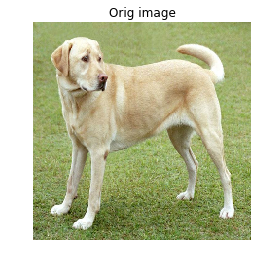

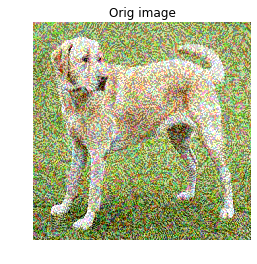

In [6]:
pgd = ProjectedGradientDescent(pretrained_model, image, image_probs)
_ = pgd.gen_adv_example(showImage=True)

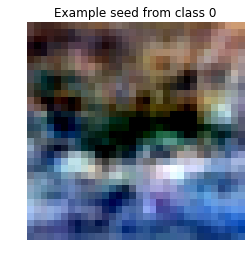

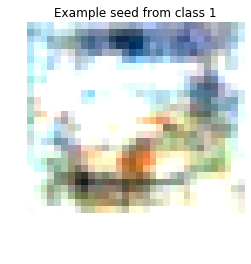

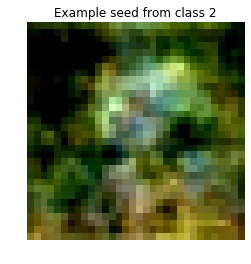

In [7]:
generator = Generator()
generator.calc_class_stats()
generator.visualize_example_seeds()